# Proximal Policy Optimization

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple, deque

In [2]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.distributions import Categorical

In [3]:
from buffer import BasicBuffer
from model import PolicyNetwork

In [4]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [5]:
plt.style.use('ggplot')

## Set Configs

In [6]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [7]:
GAMMA = 0.99
PRINT_EVERY = 20

LR = 2e-3
BETAS = (0.9, 0.999)
EPS_CLIP = 0.2
K_EPOCHS = 4
UPDATE_TIME_STEP = 2000

## Set Environment

In [8]:
ENV_NAME = 'LunarLander-v2'
env = gym.make(ENV_NAME).unwrapped; env.seed(90);

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [9]:
print('Environment Display:')
env.reset() # reset environment to a new, random state
env.render()

print('State space {}'.format(env.observation_space))
print('Action space {}'.format(env.action_space))

Environment Display:
State space Box(8,)
Action space Discrete(4)


## Define [PPO](https://arxiv.org/pdf/1707.06347.pdf) Agent

In [10]:
class PPOAgent():
    """The Agent that will interacts with and learns from the environment."""
    
    def __init__(self, env, seed):
        """Initialize an Agent object."""
        
        self.env = env
        
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        
        self.gamma = GAMMA
        self.lr = LR
        self.betas = BETAS
        self.eps_clip = EPS_CLIP
        self.K_epochs = K_EPOCHS

        self.policy = PolicyNetwork(self.state_size, self.action_size, seed).to(device)
        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr=self.lr, betas=self.betas)
        
        self.policy_old = PolicyNetwork(self.state_size, self.action_size, seed).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        # set buffer
        self.buffer = BasicBuffer()
        
        # set loss function
        self.mse_loss = nn.MSELoss()
        
    def compute_action(self, state, action_probs):
    
        dist = Categorical(action_probs)
        action = dist.sample()
        
        self.buffer.states.append(state)
        self.buffer.actions.append(action)
        self.buffer.log_probs.append(dist.log_prob(action))
        
        return action.item()
    
    def act(self, state):
        
        state = torch.FloatTensor(state).to(device) 
        
        action_probs = self.policy_old.act(state)
        action = self.compute_action(state, action_probs)
        
        return action
    
    def evaluate_policy(self, state, action):
        
        action_probs = self.policy.act(state) # discrete action spaces
        dist = Categorical(action_probs)
        
        action_log_prob = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_value = self.policy.evaluate(state)
        
        return action_log_prob, torch.squeeze(state_value), dist_entropy
    
    def learn(self):
        
        rewards = []
        discounted_reward = 0
        
        # reward calculation only use the future rewards and ignore past rewards
        for reward, done in zip(reversed(self.buffer.rewards), reversed(self.buffer.dones)):
            if done:
                discounted_reward = 0
                
            # rewards plus next state values
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
            
        # normalize the rewards
        rewards = torch.tensor(rewards).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        
        # convert list to tensor for implementing importance sampling
        old_states = torch.stack(self.buffer.states).to(device).detach()
        old_actions = torch.stack(self.buffer.actions).to(device).detach()
        old_log_probs = torch.stack(self.buffer.log_probs).to(device).detach()
        
        # optimize policy for K epochs without generating new trajectories
        for _ in range(self.K_epochs):
            
            # evaluate old actions and values to learn surrogate function
            log_probs, state_values, dist_entropy = self.evaluate_policy(old_states, old_actions)
            
            # find the ratio of pi_theta and pi_theta_old
            ratios = torch.exp(log_probs - old_log_probs.detach())
            
            # compute surrogate function (clip it to ensure that the new policy remains close to the old one)
            advantages = rewards - state_values.detach() # TD estimate as a baseline
            surrogate1 = ratios * advantages
            surrogate2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surrogate1, surrogate2) + 0.5 * self.mse_loss(rewards, state_values) - 0.01 * dist_entropy
            loss = loss.mean()
            
            # backpropagate gradient loss
            self.policy_optimizer.zero_grad()
            loss.backward()
            self.policy_optimizer.step()
        
        # copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())
        
    def save(self, policy_path):
        
        if not os.path.exists('./agents/'): os.makedirs('./agents/')
        torch.save(self.policy.state_dict(), policy_path)
        
    def watch(self, num_episodes):
        
        for i_episode in range(1, num_episodes+1):
    
            state = env.reset()
            rewards = []
            for time_step in range(1000):

                env.render() # render the screen

                action = self.act(state) # select an action
                next_state, reward, done, _ = env.step(action)

                state = next_state
                rewards.append(reward)
                if done:
                    break

            print(f'\rEpisode: {i_episode}, Average Score: {sum(rewards):.2f}')

        env.close()

In [11]:
agent = PPOAgent(env, seed=90)

## Train The Agent

In [12]:
def train_agent(num_episodes=50000, max_time=300):
    
    scores = []
    scores_window = deque(maxlen=PRINT_EVERY)
    
    time_to_update = 0
    average_length = 0
    
    # training loop
    for i_episode in range(1, num_episodes+1):

        state = env.reset()
        score = 0
        
        for time_step in range(max_time):
            
            time_to_update +=1
            
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            
            # saving reward and done
            agent.buffer.rewards.append(reward)
            agent.buffer.dones.append(done)
            
            # update agent
            if time_to_update % UPDATE_TIME_STEP == 0:
                agent.learn()
                agent.buffer.clear_memory()
                time_to_update = 0
                
            state = next_state
            score += reward
            if done:
                break
                
        average_length += time_step
                
        scores_window.append(score)
        scores.append(score)
        
        print(f'\rEpisode: {i_episode}, Average Length: {average_length/PRINT_EVERY}, Average Score: {np.mean(scores_window):.2f}', end='')
        
        if i_episode % PRINT_EVERY == 0:
            print(f'\rEpisode: {i_episode}, Average Length: {average_length/PRINT_EVERY}, Average Score: {np.mean(scores_window):.2f}')
            average_length = 0
            
        if np.mean(scores_window) >= 200.0:
            print(f'\nEnvironment solved in {i_episode:d} episodes!, Average Length: {average_length}, Average Score: {np.mean(scores_window):.2f}')
            break
    
    agent.save(f'./agents/PPO_{ENV_NAME}.pth')
    print('Training completed.')
    
    return scores

In [13]:
scores = train_agent(num_episodes=50000, max_time=300)

Episode: 20, Average Length: 80.5, Average Score: -229.932
Episode: 40, Average Length: 89.25, Average Score: -203.43
Episode: 60, Average Length: 85.6, Average Score: -171.671
Episode: 80, Average Length: 97.5, Average Score: -196.121
Episode: 100, Average Length: 109.3, Average Score: -176.62
Episode: 120, Average Length: 107.65, Average Score: -157.39
Episode: 140, Average Length: 115.15, Average Score: -182.83
Episode: 160, Average Length: 122.35, Average Score: -174.64
Episode: 180, Average Length: 149.65, Average Score: -134.67
Episode: 200, Average Length: 201.4, Average Score: -181.734
Episode: 220, Average Length: 189.85, Average Score: -97.817
Episode: 240, Average Length: 185.9, Average Score: -84.509
Episode: 260, Average Length: 222.55, Average Score: -58.98
Episode: 280, Average Length: 207.9, Average Score: -22.055
Episode: 300, Average Length: 184.8, Average Score: -27.482
Episode: 320, Average Length: 234.65, Average Score: -32.63
Episode: 340, Average Length: 289.25, 

## Evaluate The Agent

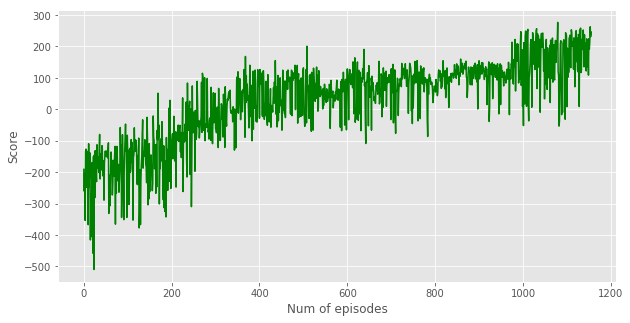

In [14]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(scores)), scores, color='green')
plt.xlabel('Num of episodes')
plt.ylabel('Score')
if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/plot_of_ppo_evaluation.png')
plt.show()

## 🎬 Watch The Smart Agent

In [15]:
agent.policy.load_state_dict(torch.load(f'./agents/PPO_{ENV_NAME}.pth'));

In [16]:
agent.watch(num_episodes=10)

Episode: 1, Average Score: 198.04
Episode: 2, Average Score: 252.75
Episode: 3, Average Score: 200.75
Episode: 4, Average Score: 246.03
Episode: 5, Average Score: 243.32
Episode: 6, Average Score: 211.36
Episode: 7, Average Score: 187.09
Episode: 8, Average Score: 206.55
Episode: 9, Average Score: 259.91
Episode: 10, Average Score: 240.24


---